### Sharpness analytics

In this notebook we define the sharpness of a board position and explore the definitions in the context of real games.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

In [2]:
player_id = 'pro'
game_id = 'ByunSangil-ShinJinseo91978'
gamedata_path = './output/'+player_id+'/analyzed_json_clean/'+game_id+'_clean.json'

In [3]:
df = pd.read_json(gamedata_path)
df.sort_index(inplace=True) # safety line, sometimes the JSONs don't automatically come sorted by turn number for some reason

### Sharpness

**Definition:**
Let $x_{n,1},\ldots,x_{n,N}$ denote the moves suggested by the AI on turn $n$.
Let $v_{n,j}$ denote the visits commited by the AI to each suggested move $x_{n,j}$, and $V_n = \sum_{j=1}^N v_{n,j}$ the total number of visits for turn $n$.
Define
$$
p_{n,j} = \frac{v_{n,j}}{V_n};
$$
in particular $\mathbf{p}_n = (p_{n,1},\ldots,p_{n,N})$ is a probability vector.
We define the *sharpness coefficient* $S_n$ at move $n$ as the $L^2$-norm of $\mathbf{p}$, i.e.
$$
S_n = \|\mathbf{p}_n\|_{L^2} = \sqrt{\sum_j p_{n,j}^2}.
$$

**Rationale:**
$\mathbf{p}_n$ is a probability vector representing the relative importance the AI places on each move, since the AI visits more important moves more frequently.
Taking the $L^2$-norm of $\mathbf{p}_n$ emphasizes those entries of $\mathbf{p}_n$ which are close to $1.0$, while killing off the effect of those entries which are close to $0$.
Consequently, $S_n$ is a measure of the degree of concentration of the mass of $\mathbf{p}_n$ into its largest entries.
It is largest when almost all visits are devoted to a single move, and smallest when the visits are equally distributed among all possible moves.

In [4]:
def sharpness(move):
    total_visits = float(sum(pd.DataFrame(df['moveInfos'][move])['visits']))
    return math.pow(sum([math.pow(x/total_visits,2) for x in pd.DataFrame(df['moveInfos'][move])['visits']]), 1/float(2))

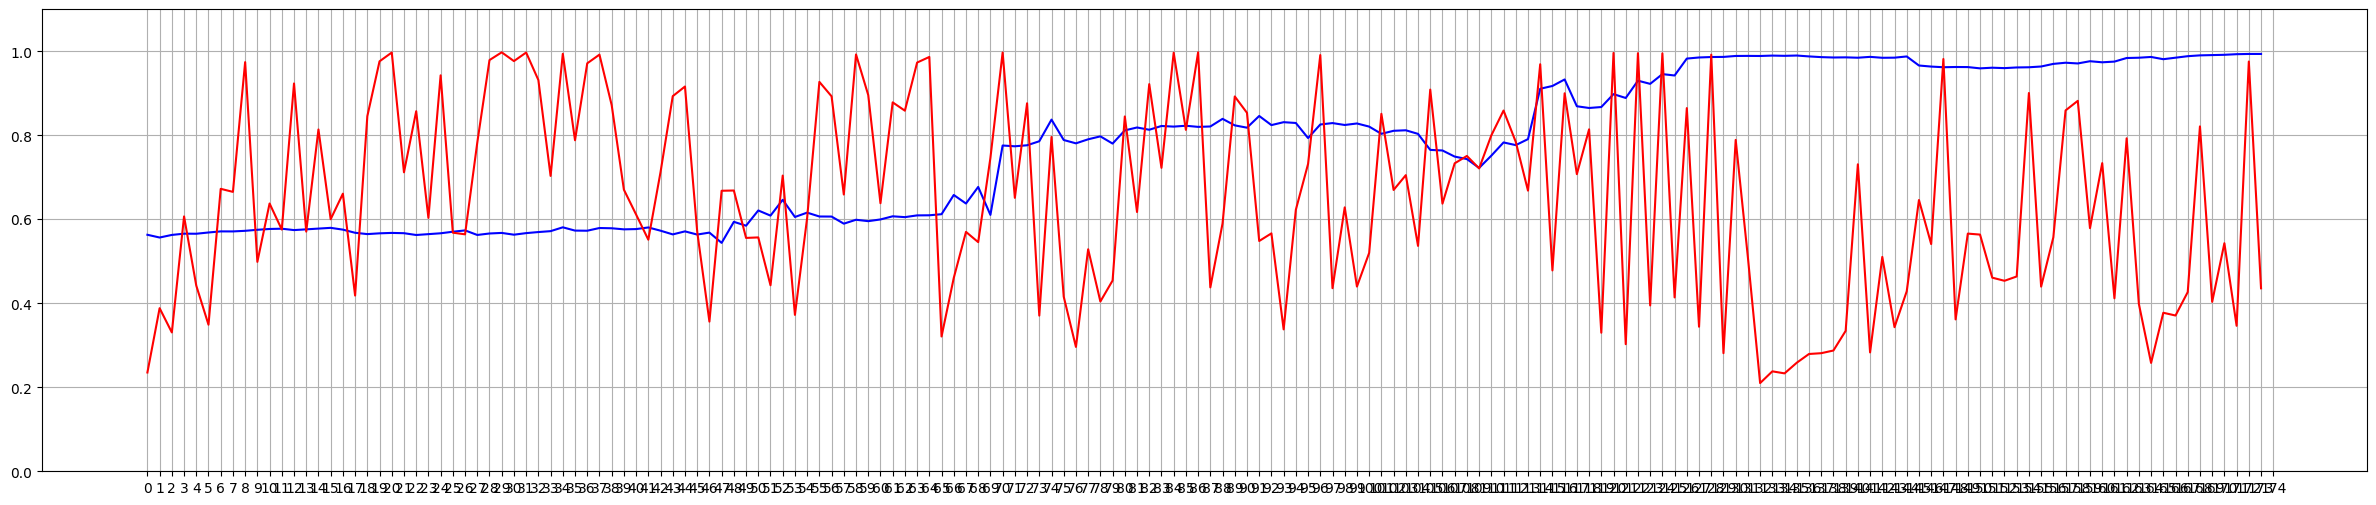

In [5]:
fig = plt.figure(figsize=(30,6))
ax = fig.add_subplot()
x_ticks = np.linspace(0, len(df.index), len(df.index)+1)
ax.set_xticks(x_ticks)
ax.set_ylim([0,1.1])
ax.grid()
# Plot winrate in blue, sharpness in red
ax.plot(range(len(df.index)), df['winrate'], color='b')
ax.plot(range(len(df.index)), [sharpness(move) for move in range(len(df.index))], color='r')

### Winrate & Sharpness plot

The above plot shows the trajectory of winrate and sharpness per move, with winrate in blue and sharpness in red.

Most completed games should show sharpness starting out at a low value, but rapidly spiking to occasional peaks (values near ~1.0).
In the early game these peaks usually correspond to sente exchanges within corner joseki.
In fact, most large peaks are indicators of moves which have at least near-sente status.

In some games there are prolonged periods of the game with a consistently high sharpness coefficient.
Often these periods correspond to those where both players are failing to notice a move that KataGo considers critical.
(Such periods are often accompanied by wild swings in winrate.)

In [6]:
df.drop(['visits','scoreSelfplay', 'weight',],axis=1,inplace=True)
df['sharpness'] = [sharpness(move) for move in range(len(df.index))]

In [7]:
column_order = ['winrate', 'scoreLead', 'utility',
                'scoreStdev', 'sharpness']
df = df[column_order]
black_moves = df.iloc[::2]
white_moves = df.iloc[1::2]
for index, row in white_moves.iterrows():
    row['winrate'] = 1-row['winrate'] # changing metric into White winrate
    row['scoreLead'] = -row['scoreLead'] # changing metric into White score lead
    row['utility'] = -row['utility']

<AxesSubplot:>

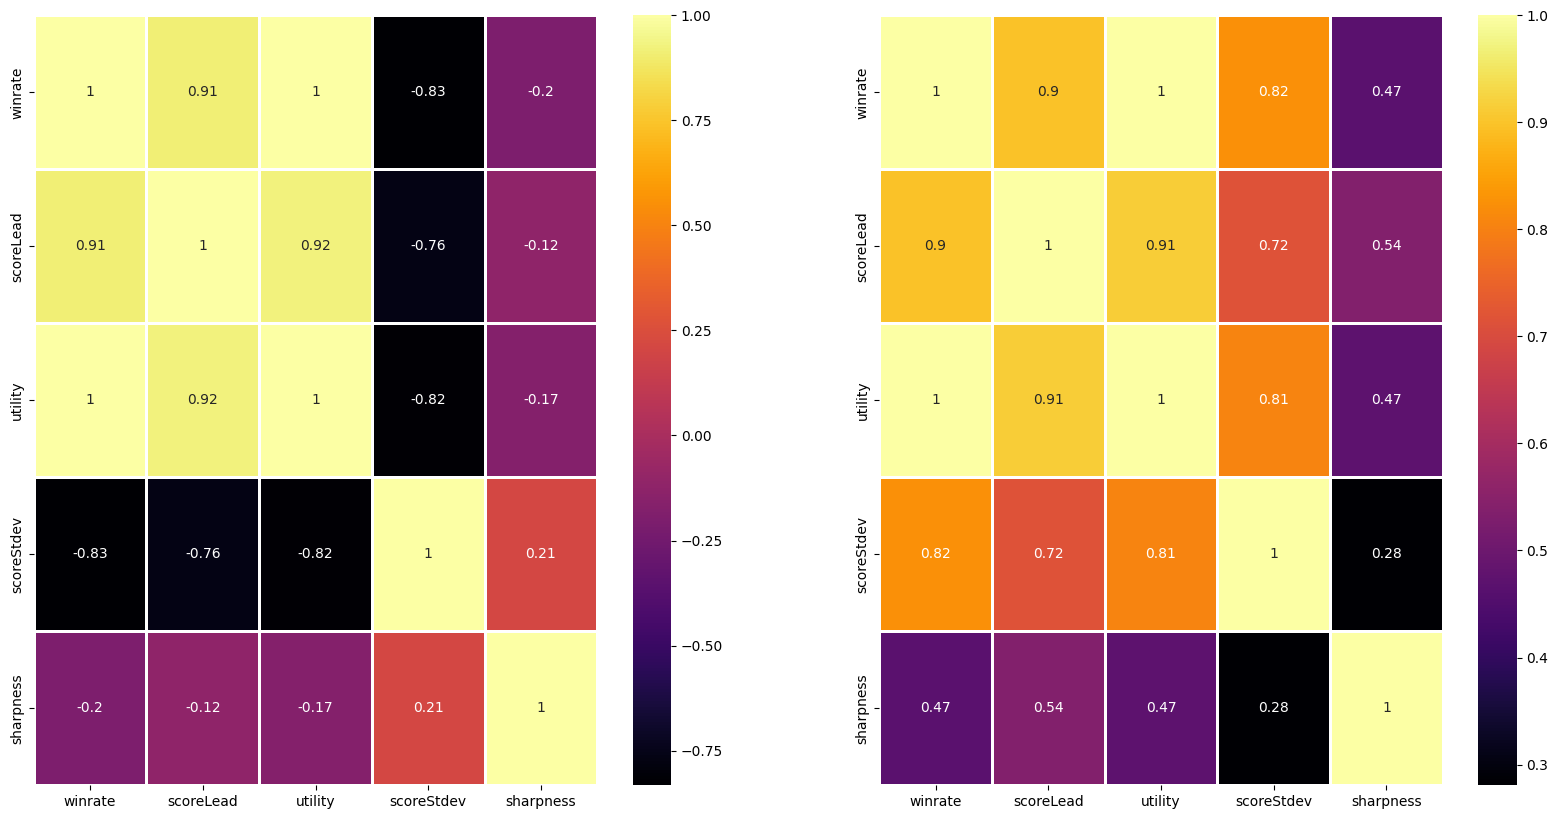

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
sns.heatmap(black_moves.corr(),annot=True,cmap='inferno',linewidths=.9, ax=ax1)
sns.heatmap(white_moves.corr(),annot=True,cmap='inferno',linewidths=.9, ax=ax2)

### Correlation coefficients

Above, we have two matrices of Pearson correlation coefficients among the numerical features in the DataFrame.
The left matrix contains correlations specifically for moves played by Black, and the right for moves played by White.
We single out the three target statistics `winrate`, `scoreLead`, and `utility` as "victory statistics" - these are the statistics that we'd like to maximize.
(For reference, `utility` is a statistic combining `winrate` and `scoreLead` used by KataGo to rank its moves.)
Here we are interested in the correlations between these statistics and our new `sharpness` coefficient - that is, the first three entries of the bottom row.

The specific values of the correlations can vary greatly from game to game, and they serve as summary statistics describing the performance of each player when faced with sharp board positions.
Here is a rough guide for intepreting the `sharpness-winrate` correlation scores (the other two correlations work similarly):

1. Magnitudes below 0.3 are considered to indicate little to no correlation. In this case, it appears unlikely that there is a linear relationship between winrate and sharpness. It suggests that the player's winrate is largely unimpacted for better or for worse by the sharpness of the board position.
2. Magnitudes between 0.3 and 0.5 are considered to indicate low correlation. In this case, there may be a weakly linear relationship between winrate and sharpness. It suggests a slight tendency for the player's winrate to be impacted in a specific direction (either positively or negatively) by the sharpness.
3. Magnitudes between 0.5 and 0.7 are considered to indicate moderate correlation. In this case, there may be a moderately linear relationship between winrate and sharpness. It suggests a moderate tendency for the player's winrate to be impacted in a specific direction (either positively or negatively) by the sharpness.
4. Magnitudes between 0.7 and 0.9 are considered to indicate high correlation. In this case, there appears to be a strongly linear relationship between winrate and sharpness. It suggests a high tendency for the player's winrate to be impacted in a specific direction (either positively or negatively) by the sharpness.
5. Magnitudes between 0.9 and 1.0 are considered to indicate very high correlation. In this case, there appears to be a very strong linear relationship between winrate and sharpness. It suggests a very consistent tendency for the player's winrate to be impacted in a specific direction (either positively or negatively) by the sharpness.

Specifically, very negative values of the `sharpness-winrate` correlation (-1.0 to -0.7) are generally bad news: it suggests that the player's performance in a sharp board position is consistently worse than in a non-sharp position, indicating consistent failures to recognize when certain moves are urgent or sente.

In this particular top-level pro game, Black's sharpness correlations are very low, suggesting very consistent play in whether in sharp or non-sharp board positions.
White's sharpness correlations are low to moderate and positive, suggesting a minor tendency to make gains in sharp positions, though those gains appear to have been insufficient to win the game outright.